<a href="https://colab.research.google.com/github/FarahArbi/BinaryClassification_PyTorch/blob/main/BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: faraharbi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 186MB/s]

In [50]:
#Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn #getting the NN layers
from torch.optim import Adam #Adam Optimiser
from torch.utils.data import Dataset, DataLoader #Dataset Class and DataLoader for creating objects
from torchsummary import summary #Model Summary
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu' # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print(device)

cpu


In [3]:
data = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [4]:
data.describe()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
count,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000,18185.000000
mean,9093.000000,7036.492989,151.680754,59.807851,0.915406,7225.817872,94.132952,0.616653,351.606949,0.707998,2.599081,0.549079
std,5249.701658,1467.197150,12.376402,10.061653,0.030575,1502.006571,9.906250,0.104389,29.500620,0.067310,0.434836,0.497599
min,1.000000,2522.000000,74.133114,34.409894,0.676647,2579.000000,56.666658,0.383239,197.015000,0.174590,1.358128,0.000000
25%,4547.000000,5962.000000,145.675910,51.393151,0.891617,6125.000000,87.126656,0.538530,333.990000,0.650962,2.208527,0.000000
50%,9093.000000,6660.000000,153.883750,55.724288,0.923259,6843.000000,92.085696,0.601194,353.088000,0.701941,2.602966,1.000000
75%,13639.000000,8423.000000,160.056214,70.156593,0.941372,8645.000000,103.559146,0.695664,373.003000,0.769280,2.964101,1.000000
max,18185.000000,10210.000000,183.211434,82.550762,0.966774,11008.000000,114.016559,0.886573,508.511000,0.904748,3.911845,1.000000


In [5]:
data.dropna(inplace=True)
data.drop(["id"], axis=1, inplace=True)
print(data.shape)

(18185, 11)


In [7]:
#Data preprocessing - normalizing
"""
data values are so big which may cause bad results
"""
original_df = data.copy()
for column in data.columns:
  data[column] = data[column] / data[column].abs().max()

data.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


Split our data into the following:

- Training Size 70%
- Validation Size 15%
- Testing Size 15%

In [8]:
#Data Spliting
X=np.array(data.drop(["Class"], axis=1))
y=np.array(data["Class"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val  = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(1637, 10)
(3819, 10)


## Binary Classification using PyTorch

**Dataset Objects:** Convert our dataset to PyTorch Dataset object as it will be more efficient during training.

In the cell below, we rebuilt the constructor function which is __init__. We put X and Y as a parameters to this function which are the inputs and outputs respectively, then inside the function we define the inputs and converting it to tensors, then converting the outputs to tensors and we make the numbers as a float32.**texte en gras** Then we modified the __len__ and the __getitem__ to match our needs which gets the specific length/shape of the data, and the data of specific row in our data respectively.

In [9]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [10]:
train_data = dataset(X_train, y_train)
Validation_data = dataset(X_val, y_val)
test_data = dataset(X_test, y_test)

In [42]:
"""
A DataLoader in PyTorch provides an iterable over the data, allowing to
efficiently load data in mini-batches, shuffle the data, and parallelize
data loading using multiple worker processes.
"""
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(Validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

for x, y in train_dataloader:
  print(x)
  print("------")
  print(y)
  break

tensor([[0.7888, 0.8924, 0.7748, 0.9519, 0.7591, 0.8882, 0.6771, 0.7530, 0.7630,
         0.6535],
        [0.6540, 0.9027, 0.6379, 0.9805, 0.6275, 0.8087, 0.6579, 0.7262, 0.6800,
         0.8028],
        [0.8897, 0.8802, 0.8785, 0.9239, 0.8467, 0.9432, 0.6367, 0.7556, 0.8547,
         0.5684],
        [0.5229, 0.8199, 0.5541, 0.9853, 0.4956, 0.7231, 0.6952, 0.6429, 0.6937,
         0.8396],
        [0.4734, 0.7112, 0.5769, 0.9628, 0.4495, 0.6880, 0.7726, 0.5818, 0.7669,
         0.6994],
        [0.8012, 0.8501, 0.8220, 0.9310, 0.7663, 0.8951, 0.8627, 0.7266, 0.8322,
         0.5868],
        [0.9352, 0.9079, 0.8949, 0.9267, 0.8894, 0.9670, 0.8477, 0.7803, 0.8423,
         0.5756],
        [0.6889, 0.7583, 0.7861, 0.9146, 0.6483, 0.8300, 0.7620, 0.6494, 0.8958,
         0.5473],
        [0.5901, 0.8411, 0.6154, 0.9765, 0.5616, 0.7682, 0.5670, 0.6785, 0.7029,
         0.7754],
        [0.9640, 0.8939, 0.9319, 0.9132, 0.9064, 0.9818, 0.8266, 0.7760, 0.8779,
         0.5442],
        [0

In [43]:
Hidden_Neurones = 10

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    """Define the Input layer as a Linear Layer,
    having input size as 10 (which is the number of columns of the input and the output
    of the number of hidden neurons) """
    self.input_layer = nn.Linear(X.shape[1],Hidden_Neurones)

    """ Output layer which have the input of hidden neurons and one
    output since we have a binary classification"""
    self.Linear = nn.Linear(Hidden_Neurones, 1)

    """ Activation function """
    self.sigmoid = nn.Sigmoid()

  #Forward propagation
  def forward(self, x):
    x = self.input_layer(x)
    x = self.Linear(x)
    x= self.sigmoid(x)
    return x

In [44]:
model = MyModel().to(device)

#summary(model, input_size = 1D input vector)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [45]:
#Loss and Optimiser
"""BCELoss = when the model's output is a single probability between 0 and 1 """
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

* total_acc_train: Tracking the training accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch. **same for 'total_acc_val'**

* total_loss_train: Tracking of the training loss progress during each epoch, we calculate the accuracy during the batch size and we use the loss value to optimize and modify the model parameters. **same for 'total_loss_val'**

In [46]:
total_acc_train_plt = []
total_loss_train_plt = []
total_acc_val_plt =[]
total_loss_val_plt =[]

""" Each epoch allows the model to adjust its weights based on the
error it made in the previous round.
"""
num_epochs = 10
for epoch in range(num_epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  #training
  for data in train_dataloader:
    x, y = data #x = input / y = label

    """Forward Propagation"""
    #Change the shape of predictions from [8,1] to [8] to match y's shape
    predictions = model(x).squeeze(1)
    batch_loss = criterion(predictions, y)

    #for each epoch, add the loss value to calculate at the end the total loss of training
    total_loss_train += batch_loss.item()

    #To calculate the accuracy by comparing the predictions and the actual labels,  we sum up the number of correct predictions (i.e., the number of True values)
    accuracy = ((predictions).round() == y).sum().item()
    total_acc_train += accuracy

    """Backward Propagation"""
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  #validation
  with torch.no_grad(): # means the model to do predicitons without being trained to calculate the validation performance
    for data in val_dataloader:
       x,y = data
       predictions = model(x).squeeze(1)
       batch_loss = criterion(predictions, y)
       total_loss_val += batch_loss.item()
       accuracy =((predictions).round() == y).sum().item()
       total_acc_val += accuracy

  total_loss_train_plt.append(round(total_loss_train/len(train_dataloader), 4))
  total_acc_train_plt.append(round(total_acc_train/(train_data.__len__())*100, 4))
  total_loss_val_plt.append(round(total_loss_val/len(val_dataloader), 4))
  total_acc_val_plt.append(round(total_acc_val/(Validation_data.__len__())*100, 4))


  print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/len(train_dataloader):.4f} Train Accuracy: {(total_acc_train/(train_data.__len__())*100):.4f}
  Validation Loss: {total_loss_val/len(val_dataloader):.4f} Validation Accuracy: {(total_acc_val/(Validation_data.__len__())*100):.4f}''')
  print("="*50)

Epoch no. 1 Train Loss: 0.6037 Train Accuracy: 80.1398 
  Validation Loss: 0.4536 Validation Accuracy: 96.1515
Epoch no. 2 Train Loss: 0.3040 Train Accuracy: 97.8867 
  Validation Loss: 0.1901 Validation Accuracy: 98.0452
Epoch no. 3 Train Loss: 0.1434 Train Accuracy: 98.2874 
  Validation Loss: 0.1074 Validation Accuracy: 98.2896
Epoch no. 4 Train Loss: 0.0924 Train Accuracy: 98.4366 
  Validation Loss: 0.0790 Validation Accuracy: 98.2896
Epoch no. 5 Train Loss: 0.0714 Train Accuracy: 98.5073 
  Validation Loss: 0.0662 Validation Accuracy: 98.2896
Epoch no. 6 Train Loss: 0.0608 Train Accuracy: 98.5152 
  Validation Loss: 0.0609 Validation Accuracy: 98.2285
Epoch no. 7 Train Loss: 0.0543 Train Accuracy: 98.5466 
  Validation Loss: 0.0628 Validation Accuracy: 98.2896
Epoch no. 8 Train Loss: 0.0507 Train Accuracy: 98.5309 
  Validation Loss: 0.0547 Validation Accuracy: 98.2896
Epoch no. 9 Train Loss: 0.0480 Train Accuracy: 98.5781 
  Validation Loss: 0.0524 Validation Accuracy: 98.3506
E

In [47]:
#Testing
with torch.no_grad():
  total_acc_test = 0
  total_loss_test = 0
  for data in test_dataloader:
    x,y = data

    prediction= model(x).squeeze(1)
    batch_loss = criterion(prediction, y)

    total_loss_test += batch_loss.item()

    accuracy = ((prediction).round() == y).sum().item()
    total_acc_test += accuracy

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 99.03%


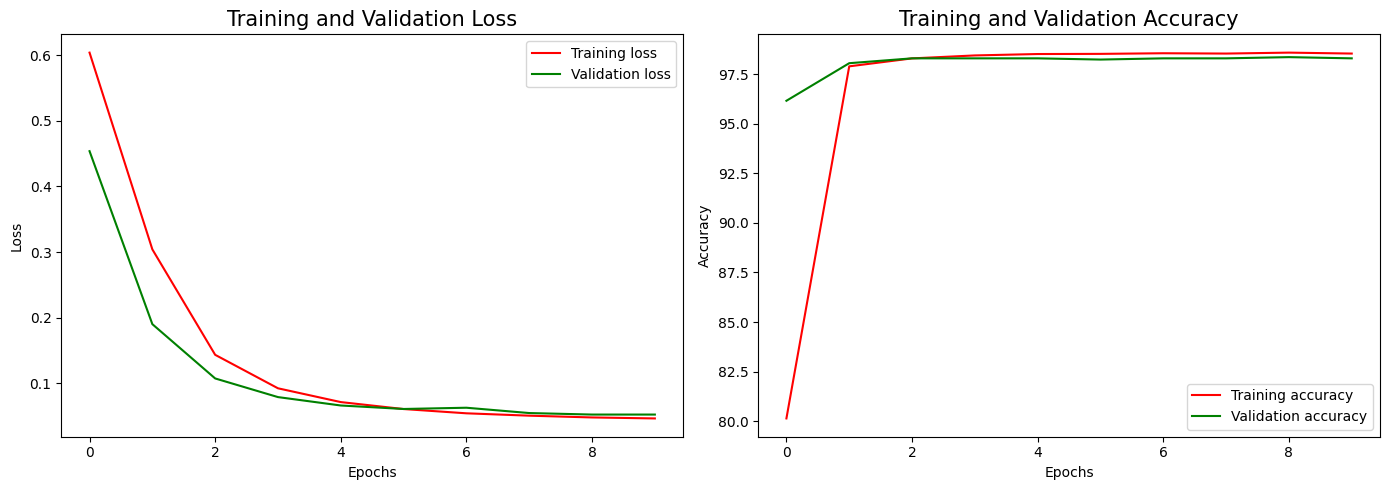

In [48]:
#Plotting and Visualisation
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

axs[0].plot(total_loss_train_plt, label="Training loss", color="red")
axs[0].plot(total_loss_val_plt, label="Validation loss", color="green")
axs[0].set_title("Training and Validation Loss", size=15)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plt, label="Training accuracy", color="red")
axs[1].plot(total_acc_val_plt, label="Validation accuracy", color="green")
axs[1].set_title("Training and Validation Accuracy", size=15)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
#Inference
"""Inference is the process of using a trained model to make predictions on new, unseen data."""

## Binary Classification using Supervised Models

In [66]:
#Knn Classidfier Training
kneighbors = 20
total_acc_val_plt =[]

for k in range(1, kneighbors):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)

  predictions = knn.predict(X_val)
  accuracy = accuracy_score(y_val, predictions)

  total_acc_val_plt.append(round((accuracy * 100), 3))

  print(f'k = {k}, Accuracy = {round((accuracy * 100), 3)}')
  print("="*50)

k = 1, Accuracy = 98.106
k = 2, Accuracy = 97.495
k = 3, Accuracy = 98.656
k = 4, Accuracy = 98.29
k = 5, Accuracy = 98.412
k = 6, Accuracy = 98.412
k = 7, Accuracy = 98.534
k = 8, Accuracy = 98.534
k = 9, Accuracy = 98.595
k = 10, Accuracy = 98.534
k = 11, Accuracy = 98.534
k = 12, Accuracy = 98.473
k = 13, Accuracy = 98.473
k = 14, Accuracy = 98.473
k = 15, Accuracy = 98.595
k = 16, Accuracy = 98.473
k = 17, Accuracy = 98.534
k = 18, Accuracy = 98.412
k = 19, Accuracy = 98.412


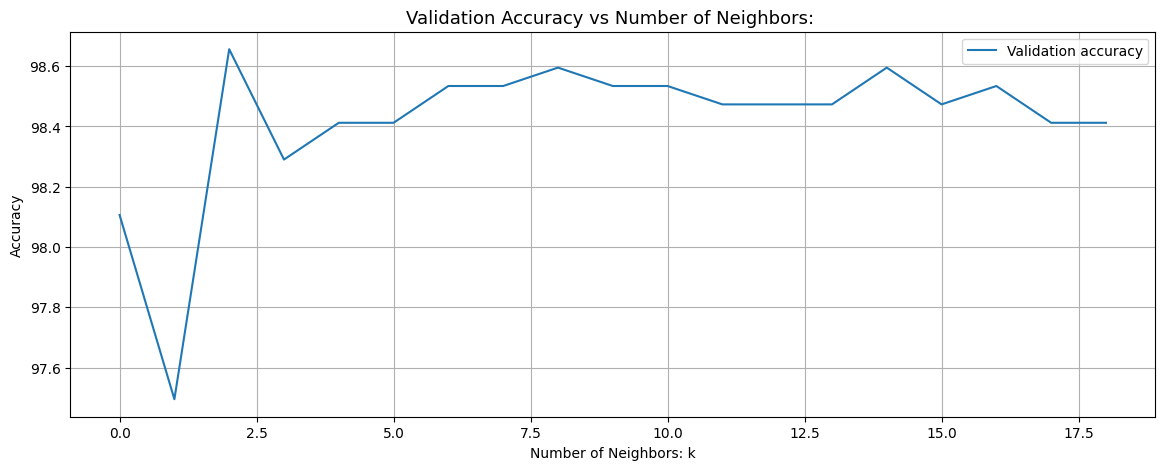

In [71]:
#Plotting and Visualisation
plt.figure(figsize = (14,5))

plt.plot(total_acc_val_plt, label="Validation accuracy")
plt.title("Validation Accuracy vs Number of Neighbors: ", size=13)
plt.xlabel("Number of Neighbors: k")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.show()

In [72]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)
accuracy= accuracy_score(y_test, predictions)

print(f'Accuracy = {round((accuracy * 100), 3)}')

Accuracy = 99.162


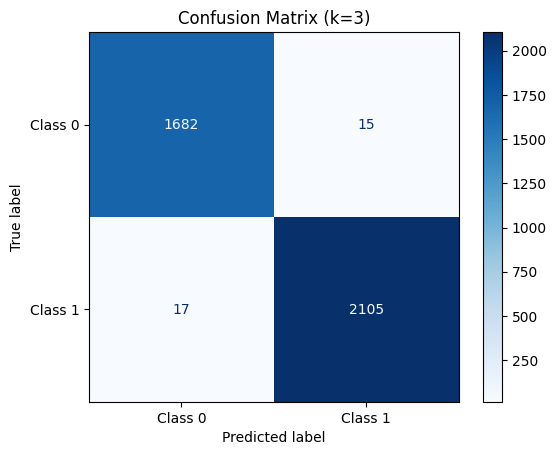

Classification Report : 
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1697
         1.0       0.99      0.99      0.99      2122

    accuracy                           0.99      3819
   macro avg       0.99      0.99      0.99      3819
weighted avg       0.99      0.99      0.99      3819



In [77]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
display.plot(cmap="Blues")
plt.title("Confusion Matrix (k=3)")
plt.show()

print("Classification Report : ")
print(classification_report(y_test, predictions))